In [1]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [2]:
!head ../input/third2/HPI_PO_monthly_hist.csv

Month,East North Central (NSA),East North Central (SA),East South Central (NSA),East South Central (SA),Middle Atlantic (NSA),Middle Atlantic (SA),Mountain  (NSA),Mountain  (SA),New England  (NSA),New England  (SA),Pacific  (NSA),Pacific  (SA),South Atlantic (NSA),South Atlantic (SA),West North Central (NSA),West North Central (SA),West South Central (NSA),West South Central (SA),USA  (NSA),USA  (SA)
1/1/1991,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
2/1/1991,100.99,101.10,100.87,100.50,100.03,100.20,98.46,98.67,102.09,102.70,100.22,100.52,100.52,100.46,100.61,100.67,99.94,99.75,100.43,100.50
3/1/1991,101.34,101.02,100.98,100.61,99.92,99.72,100.19,100.57,101.69,101.39,100.02,100.15,100.97,100.62,100.41,100.15,100.79,100.51,100.71,100.51
4/1/1991,101.76,101.08,100.88,100.61,99.32,99.08,100.39,100.36,101.11,100.95,100.18,100.08,100.98,100.53,100.91,100.46,100.44,100.08,100.71,100.36
5/1/1991

In [79]:
def read_po_monthly_hpi():
    df=pd.read_csv("../input/third2/HPI_PO_monthly_hist.csv", parse_dates=['Month'])
    #df=df[df['state'].isin({'IA','CA','NY','NC','OH'})]
    cols=[u for u in df.columns if 'NSA' in u] +['Month']
    df=df[cols]
    cols=[u.split('(')[0].strip() for u in df.columns]
    df.columns=cols
    df=df[['Month','Middle Atlantic','East North Central','West North Central', 'South Atlantic','Pacific']]
    df=df[df.Month>=pd.to_datetime('2006-1-1')]
    df=df.set_index('Month')
    df.columns=["MA",'ENC','WNC','SA','PAC']
    assert df.isnull().sum().sum()==0
    return df

In [80]:
monthly_hpi=read_po_monthly_hpi()

In [81]:
monthly_hpi.head()

MA     ENC     WNC      SA     PAC
Month                                             
2006-01-01  214.70  192.15  209.18  233.71  276.52
2006-02-01  213.59  192.48  210.17  234.10  280.83
2006-03-01  215.60  193.30  211.50  236.95  280.81
2006-04-01  216.56  195.55  212.62  238.55  282.50
2006-05-01  218.55  197.05  214.28  239.59  284.26

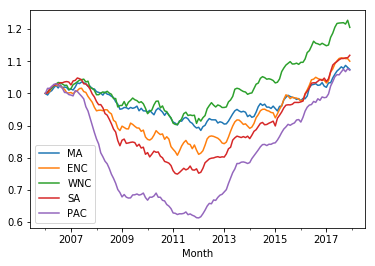

In [82]:
(monthly_hpi/monthly_hpi.iloc[0]).plot()

In [31]:
!head ../input/third2/HPI_PO_us_and_census.txt

In [75]:
def read_po_quater_hpi():
    df=pd.read_csv("../input/third2/HPI_PO_us_and_census.txt" ,sep="\t")
    df['hpi']=df['index_po_not_seasonally_adjusted'].astype(np.float)
    df=df[df.year>2005]
    df['division']=df['division'].map(lambda u: u.split("_")[-1])
    df=df[df['division'].isin({"MA",'ENC','WNC','SA','PAC','USA'})]
    df['Month']=pd.to_datetime(df.apply(lambda u: '{}-{}-{}'.format(u['year'], (u['qtr']-1)*3+2,1),axis=1))
    df=df.drop(['index_po_not_seasonally_adjusted','index_po_seasonally_adjusted'],axis=1)
    df=pd.pivot_table(df,index='Month', columns='division',values='hpi')
    df=df[["MA",'ENC','WNC','SA','PAC']]
    assert df.isnull().sum().sum()==0
    return df

In [76]:
quater_hpi=read_po_quater_hpi()

In [77]:
quater_hpi.head()

division        MA     ENC     WNC      SA     PAC
Month                                             
2006-02-01  214.51  190.74  208.64  232.79  278.65
2006-05-01  218.46  194.45  212.35  237.39  283.04
2006-08-01  219.04  194.16  213.62  238.71  281.32
2006-11-01  217.97  191.25  211.48  239.78  275.78
2007-02-01  217.77  190.48  212.48  239.99  275.71

In [78]:
(quater_hpi/quater_hpi.iloc[0]).plot()

In [89]:
quater_hpi=quater_hpi/quater_hpi.iloc[0]
monthly_hpi=monthly_hpi/monthly_hpi.iloc[0]

MA


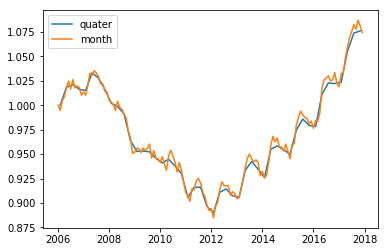

ENC


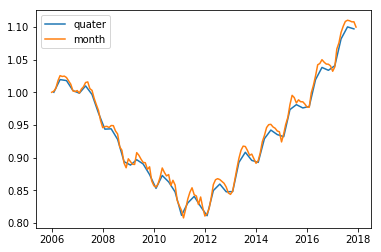

WNC


SA


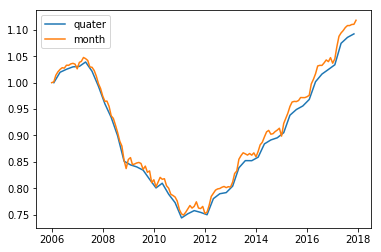

PAC


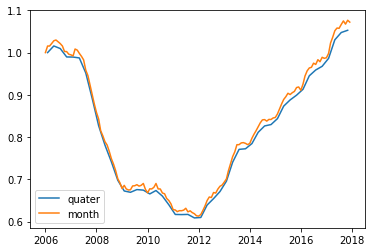

In [90]:
for col in quater_hpi.columns:
    print col
    plt.plot(quater_hpi[col])
    plt.plot(monthly_hpi[col])
    plt.legend(['quater','month'])
    plt.show()

MA
-0.00270044625962 0.00387157861737


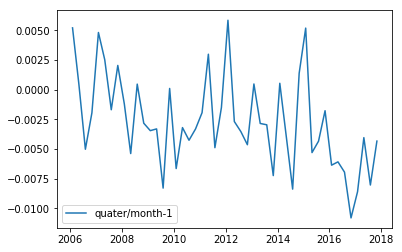

ENC
-0.00649014389449 0.00433579551974


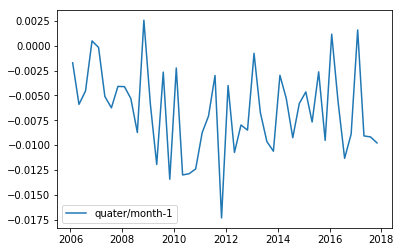

WNC
-0.0110143814771 0.00502795338809


SA
-0.0110925618346 0.00505629269896


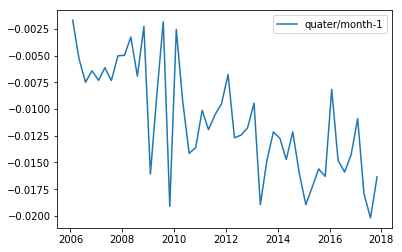

PAC
-0.0148171560309 0.0046747923614


In [110]:
for col in quater_hpi.columns:
    print col
    a= quater_hpi[col]/monthly_hpi[col]-1
    plt.plot(a.dropna())
    print np.mean(a.dropna()),np.std(a.dropna())
    plt.legend(['quater/month-1'])
    plt.show()